In [1]:
import time
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
import xgboost as xgb
from scipy import interp

from collections import Counter
from sklearn import metrics, preprocessing, linear_model
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_score, recall_score,
    f1_score, accuracy_score, classification_report
)
from sklearn.model_selection import (
    train_test_split, KFold, GridSearchCV, StratifiedKFold
)
from sklearn.manifold import TSNE
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn import over_sampling
from imblearn.over_sampling import RandomOverSampler

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Drop the 'Time' column from the DataFrame
df = df.drop("Time", axis=1)
df.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Assign the 'Class' column as the target variable y
y = df["Class"]

# Create the feature matrix X by dropping the 'Class' column
X = df.drop("Class", axis=1)

# Print the shapes of y and X
print("Shape of y:", y.shape)
print("Shape of X:", X.shape)


Shape of y: (284807,)
Shape of X: (284807, 29)


In [5]:
# Splitting the data into 80:20 train test size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (227845, 29)
Shape of X_test: (56962, 29)
Shape of y_train: (227845,)
Shape of y_test: (56962,)


In [6]:
print("Fraudulent Count for Full data:", np.sum(y))
print("Fraudulent Count for Train data:", np.sum(y_train))
print("Fraudulent Count for Test data:", np.sum(y_test))


Fraudulent Count for Full data: 492
Fraudulent Count for Train data: 394
Fraudulent Count for Test data: 98


In [7]:
X_test_saved = X_test.copy()
y_test_saved = y_test.copy()
print("Testing set saved for evaluation.")


Testing set saved for evaluation.


In [8]:
# Initialize the RobustScaler
scaler = RobustScaler()

# Scaling the "Amount" feature in the training data
X_train[["Amount"]] = scaler.fit_transform(X_train[["Amount"]])

# Scaling the "Amount" feature in the test data
X_test[["Amount"]] = scaler.transform(X_test[["Amount"]])

# Calculate skewness of features
var = X_train.columns
skewness_list = []
for col in var:
    skewness_list.append(X_train[col].skew())

# Create a DataFrame to store skewness values
skewness_df = pd.DataFrame({"Features": var, "Skewness": skewness_list})
skewness_df.set_index("Features", inplace=True)
skewness_df

# Identify skewed features
skewed_features = skewness_df[(skewness_df["Skewness"] > 1) | (skewness_df["Skewness"] < -1)].index
skewed_features.tolist()

# Importing the required library
from sklearn import preprocessing

# Instantiate the PowerTransformer
pt = preprocessing.PowerTransformer(method='yeo-johnson', copy=True)

# Fit and transform the training data
X_train_pt = pt.fit_transform(X_train)
y_train_pt = y_train

# Transform the test data using the same transformer
X_test_pt = pt.transform(X_test)
y_test_pt = y_test


In [9]:
# Display the power-transformed features
print(X_train_pt)


[[ 1.33618788 -0.54484524 -0.96560586 ...  0.18226012 -0.09086395
  -0.84312016]
 [ 1.42577426 -0.11673724 -1.77657609 ... -0.00550109 -0.20559691
  -1.07812706]
 [-0.75438698  0.33048345  0.39988107 ...  0.08314307  0.57984412
   1.43122753]
 ...
 [ 0.52096648 -0.03765332  0.22167732 ...  0.06556876  0.08664086
   0.39825955]
 [ 0.70400402  0.11684072  0.09210173 ... -0.1603766  -0.00883583
  -1.20086971]
 [-0.57696779  0.45583121  1.4321219  ...  0.94608931  0.64393801
  -0.86019457]]


In [10]:
# Conducting cross-validation for both X_train and y_train datasets.
# Initialize a StratifiedKFold cross-validator for performing cross-validation.

num_splits = 3
random_state = None
shuffle_data = False  # The shuffling of data is disabled by setting shuffle to False in order to maintain consistent results during cross-validation.

skf = StratifiedKFold(n_splits=num_splits, random_state=random_state, shuffle=shuffle_data)


Running Decision Tree Classifier...
Evaluating model with max depth of 1...
Fold completed. Time taken: 4.81 seconds
Fold completed. Time taken: 2.20 seconds
Fold completed. Time taken: 1.71 seconds
For Depth 1:
Mean ROC-AUC: 0.8260369152950421
Precision: 0.7687499999999999, Recall: 0.6524211581463489, F1-Score: 0.7037697164558141
----------------------------------------------------------------------------------------------------
Evaluating model with max depth of 2...
Fold completed. Time taken: 7.12 seconds
Fold completed. Time taken: 4.74 seconds
Fold completed. Time taken: 4.23 seconds
For Depth 2:
Mean ROC-AUC: 0.8691790232260899
Precision: 0.8341073210128748, Recall: 0.7006130002313209, F1-Score: 0.7595286393889774
----------------------------------------------------------------------------------------------------
Evaluating model with max depth of 3...
Fold completed. Time taken: 6.08 seconds
Fold completed. Time taken: 9.07 seconds
Fold completed. Time taken: 9.52 seconds
For D

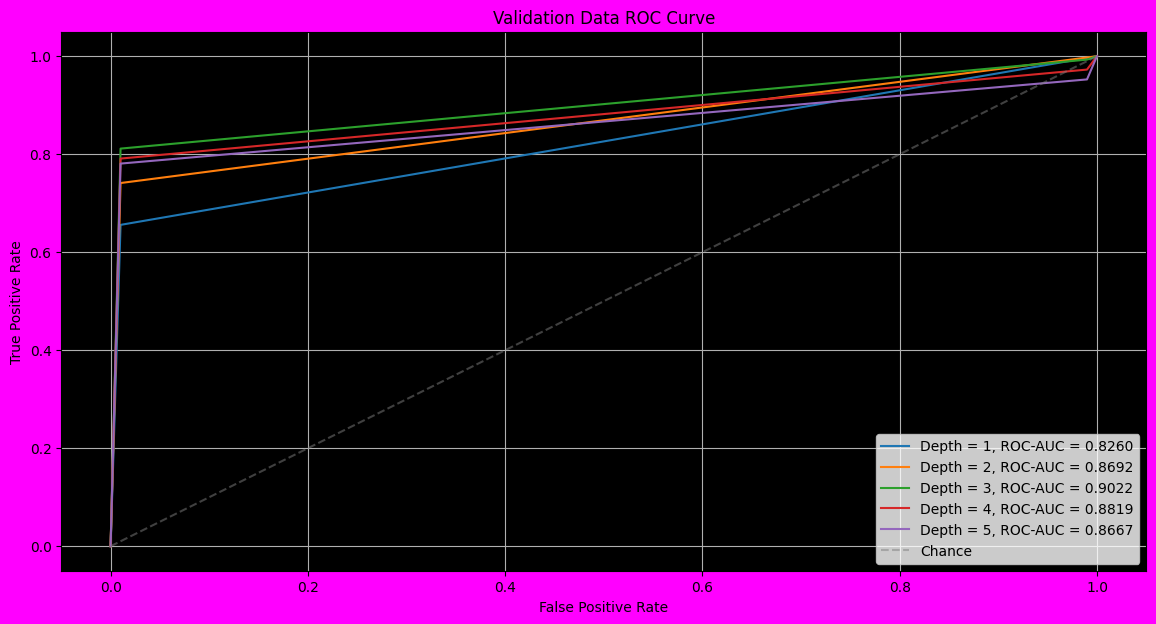

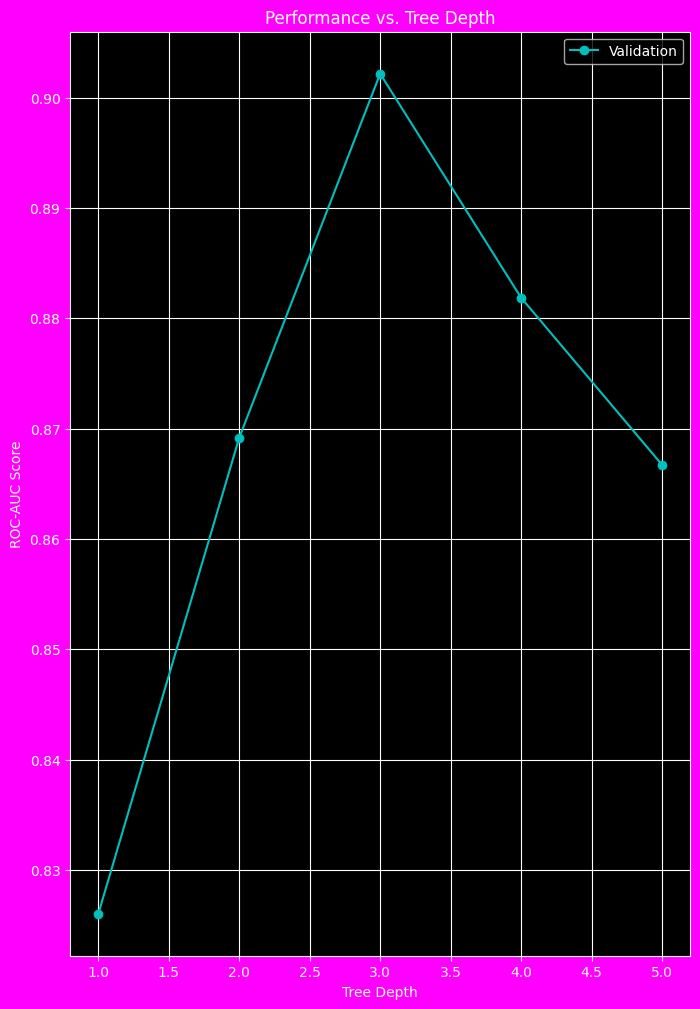

Summary of Best Performance:
Optimal Depth: 3
Best ROC-AUC Score: 0.9021649217336111
Precision: 0.847851129818343, Recall: 0.7132778163312513, F1-Score: 0.7734128803366911


In [11]:
print("Running Decision Tree Classifier...")

# Potential max depth values for the decision tree
depth_values = [1, 2, 3, 4, 5]

# Lists to hold evaluation metrics for validation data
roc_auc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
average_fpr = np.linspace(0, 1, 100)

# Initialize a plot for the ROC curves
fig, ax2= plt.subplots(figsize=(14, 7), facecolor='fuchsia') 
ax2.set_facecolor('black')

# Evaluate performance for each depth value
for depth in depth_values:
    print(f"Evaluating model with max depth of {depth}...")
    scores = []
    precision = []
    recall = []
    f1 = []
    val_fprs = []
    val_tprs = []

    # Cross-validation loop
    for train_idx, val_idx in skf.split(X_train_pt, y_train_pt):
        timer_start = time.time()

        X_cv_train, X_cv_val = X_train_pt[train_idx], X_train_pt[val_idx]
        y_cv_train, y_cv_val = y_train_pt.iloc[train_idx], y_train_pt.iloc[val_idx]

        tree = DecisionTreeClassifier(max_depth=depth)
        tree.fit(X_cv_train, y_cv_train)

        predictions = tree.predict_proba(X_cv_val)
        score = roc_auc_score(y_true=y_cv_val, y_score=predictions[:, 1])
        scores.append(score)

        binary_predictions = (predictions[:, 1] >= 0.5).astype(int)
        precision.append(precision_score(y_cv_val, binary_predictions))
        recall.append(recall_score(y_cv_val, binary_predictions))
        f1.append(f1_score(y_cv_val, binary_predictions))

        val_fpr, val_tpr, _ = roc_curve(y_true=y_cv_val, y_score=predictions[:, 1])
        val_tprs.append(interp(average_fpr, val_fpr, val_tpr))
        val_tprs[-1][0] = 0.0

        timer_end = time.time()
        print(f"Fold completed. Time taken: {timer_end - timer_start:.2f} seconds")

    # Compute mean of metrics and store them
    roc_auc_scores.append(np.mean(scores))
    precision_scores.append(np.mean(precision))
    recall_scores.append(np.mean(recall))
    f1_scores.append(np.mean(f1))

    # Display performance metrics
    print(f"For Depth {depth}:")
    print(f"Mean ROC-AUC: {roc_auc_scores[-1]}")
    print(f"Precision: {precision_scores[-1]}, Recall: {recall_scores[-1]}, F1-Score: {f1_scores[-1]}")
    print("-" * 100)

    # Plot ROC curve for the current depth value
    ax2.plot(average_fpr, np.mean(val_tprs, axis=0), label=f'Depth = {depth}, ROC-AUC = {roc_auc_scores[-1]:.4f}')

print("Completed Decision Tree Evaluations")
print("Plotting ROC-AUC curves...")

# Plotting random classifier for reference
ax2.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Chance', alpha=0.5)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Validation Data ROC Curve')
ax2.legend()
ax2.grid(True)

plt.show()

# Plotting ROC-AUC scores vs. Depth
with plt.style.context('dark_background'):
    plt.figure(figsize=(8, 12), facecolor='magenta')
    plt.plot(depth_values, roc_auc_scores, 'co-')
    plt.xlabel('Tree Depth')
    plt.ylabel('ROC-AUC Score')
    plt.title('Performance vs. Tree Depth')
    plt.legend(['Validation'], loc='upper right')
    plt.grid(True)
    plt.show()

print("Summary of Best Performance:")
print(f"Optimal Depth: {depth_values[np.argmax(roc_auc_scores)]}")
print(f"Best ROC-AUC Score: {max(roc_auc_scores)}")
print(f"Precision: {precision_scores[np.argmax(roc_auc_scores)]}, Recall: {recall_scores[np.argmax(roc_auc_scores)]}, F1-Score: {f1_scores[np.argmax(roc_auc_scores)]}")


In [12]:
# Creating a Decision Tree classifier
tree_classifier = DecisionTreeClassifier(random_state=42)

# Defining the hyperparameters to be tuned
tuning_params = {'max_depth': [2, 3, 4],
                 'min_samples_split': [2, 5, 10],
                 'min_samples_leaf': [1, 2, 4],
                 'criterion': ['gini', 'entropy']}

# Setting up GridSearchCV with stratified cross-validation
start_tick = time.time()
grid_search_model = GridSearchCV(tree_classifier,
                        param_grid=tuning_params,
                        scoring='roc_auc',
                        cv=skf,
                        n_jobs=-1,
                        verbose=1,
                        return_train_score=True)

# Fitting the model to discover the best parameters
grid_search_model.fit(X_train_pt, y_train_pt)

end_tick = time.time()

# Displaying the time taken for model tuning
print(f"Model tuning completed in: {end_tick - start_tick:.2f} seconds.")

# Showcasing the best ROC AUC score obtained
print(f'Optimal ROC AUC score: {grid_search_model.best_score_:.4f}')

# Revealing the best hyperparameters from the tuning
print(f'Optimal parameters: {grid_search_model.best_params_}')


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Model tuning completed in: 255.41 seconds.
Optimal ROC AUC score: 0.9337
Optimal parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [13]:
# Extracting the results from GridSearch
search_results = grid_search_model.cv_results_

# Display the average scores for each parameter set
print("Average test scores across parameter sets:")
for score, setting in zip(search_results["mean_test_score"], search_results["params"]):
    print(f"For {setting}, Score: {score:.4f}")

# Highlighting the ranking of each parameter set based on test scores
print("\nParameter set rankings:")
for position, setting in enumerate(search_results["params"], start=1):
    print(f"Rank {position}: {setting}")

# Show the variability in test scores for each parameter set
print("\nTest score variability across parameter sets:")
for deviation, setting in zip(search_results["std_test_score"], search_results["params"]):
    print(f"For {setting}, Std Dev: {deviation:.4f}")


Average test scores across parameter sets:
For {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}, Score: 0.8692
For {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5}, Score: 0.8692
For {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 10}, Score: 0.8692
For {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}, Score: 0.8692
For {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 5}, Score: 0.8692
For {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 10}, Score: 0.8692
For {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 2}, Score: 0.8692
For {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 5}, Score: 0.8692
For {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 10}, Score: 0.8692
For {'criterion': 

In [14]:
# Initialize the SMOTE resampler with a given random state
smote = over_sampling.SMOTE(random_state=0)

# Apply the resampling to the training data
X_smote_train_pt, y_smote_train_pt = smote.fit_resample(X_train_pt, y_train_pt)

================================= Starting Decision Tree Evaluation ======================================
Evaluating for Depth: 1
Training Set: [ 75936  75937  75938 ... 454899 454900 454901], Validation Set: [     0      1      2 ... 303265 303266 303267]
Completed in 3.93 seconds.
Training Set: [     0      1      2 ... 454899 454900 454901], Validation Set: [ 75936  75937  75938 ... 379082 379083 379084]
Completed in 3.78 seconds.
Training Set: [     0      1      2 ... 379082 379083 379084], Validation Set: [151894 151895 151896 ... 454899 454900 454901]
Completed in 3.89 seconds.
Validation ROC-AUC: 0.9236
Validation Precision: 0.9679
Validation Recall: 0.8763
Validation F1-Score: 0.9198
----------------------------------------------------------------------------------------------------
Evaluating for Depth: 2
Training Set: [ 75936  75937  75938 ... 454899 454900 454901], Validation Set: [     0      1      2 ... 303265 303266 303267]
Completed in 6.99 seconds.
Training Set: [   

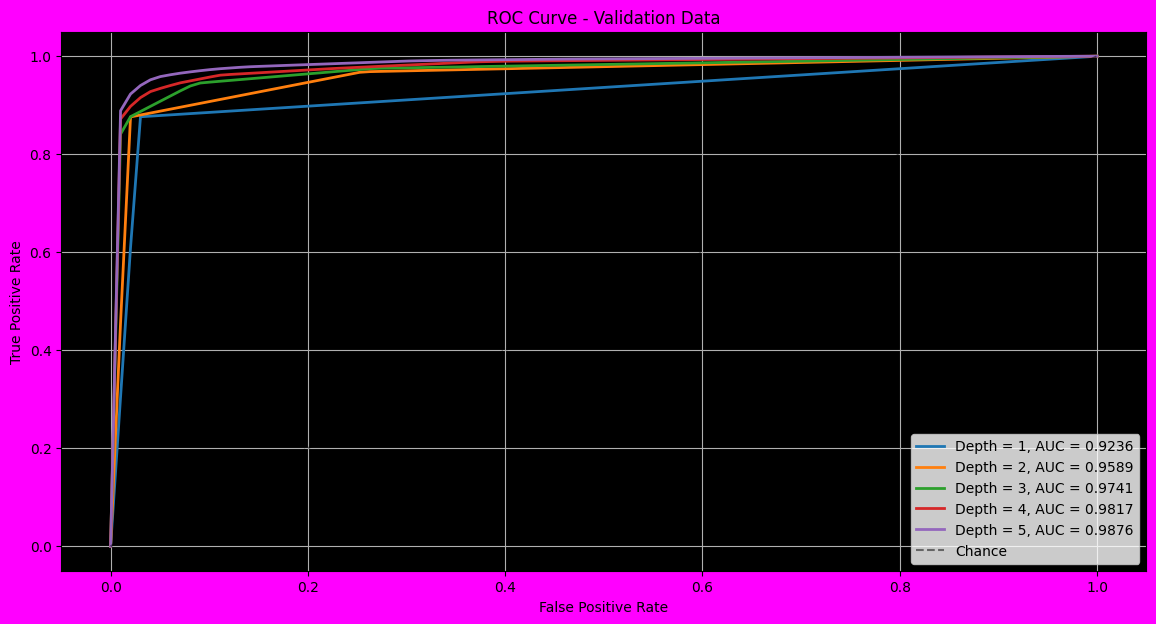

================================= ROC Curve Displayed ====================================


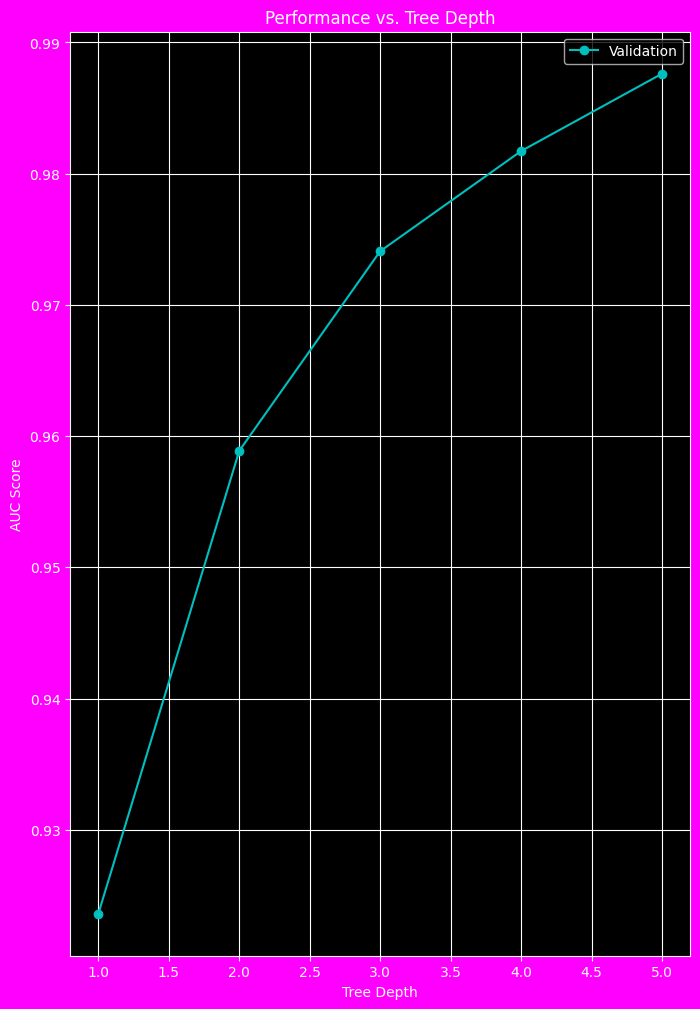


Highlighting the Best Results

ROC-AUC Scores across depths: [0.9236033255514374, 0.9588771035915595, 0.9740918136010585, 0.9817219012906652, 0.9876182390507088]
Optimal Depth: 5
Best AUC: 0.9876
Precision at Optimal Depth: 0.9560
Recall at Optimal Depth: 0.9561
F1-Score at Optimal Depth: 0.9560
================================= Decision Tree Analysis Over ====================================


In [15]:
print("================================= Starting Decision Tree Evaluation ======================================")

# Specify potential depth values for the Decision Tree
depths = [1, 2, 3, 4, 5]

# Prepare lists to store evaluation metrics
roc_auc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
avg_fpr = np.linspace(0, 1, 100)

# Setting up the plotting canvas
fig, ax2 = plt.subplots(figsize=(14, 7), facecolor='fuchsia')
ax2.set_facecolor('black')

# Evaluate the Decision Tree for each depth value
for depth in depths:
    print(f"Evaluating for Depth: {depth}")
    scores, precisions, recalls, f1s = [], [], [], []
    fprs, tprs = [], []

    # Stratified cross-validation
    for train_idx, val_idx in skf.split(X_smote_train_pt, y_smote_train_pt):
        timer_start = time.time()
        print(f"Training Set: {train_idx}, Validation Set: {val_idx}")
        
        X_train_subset, X_val_subset = X_smote_train_pt[train_idx], X_smote_train_pt[val_idx]
        y_train_subset, y_val_subset = y_smote_train_pt.iloc[train_idx], y_smote_train_pt.iloc[val_idx]

        # Train Decision Tree
        tree = DecisionTreeClassifier(max_depth=depth)
        tree.fit(X_train_subset, y_train_subset)

        # Validation predictions
        y_val_predictions = tree.predict_proba(X_val_subset)
        
        # Evaluation metrics
        score = roc_auc_score(y_val_subset, y_val_predictions[:, 1])
        scores.append(score)

        y_val_binary_predictions = (y_val_predictions[:, 1] >= 0.5).astype(int)
        precisions.append(precision_score(y_val_subset, y_val_binary_predictions))
        recalls.append(recall_score(y_val_subset, y_val_binary_predictions))
        f1s.append(f1_score(y_val_subset, y_val_binary_predictions))

        fpr, tpr, _ = roc_curve(y_val_subset, y_val_predictions[:, 1])
        tprs.append(interp(avg_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

        elapsed = time.time() - timer_start
        print(f"Completed in {elapsed:.2f} seconds.")

    # Aggregate metrics
    roc_auc_scores.append(np.mean(scores))
    precision_scores.append(np.mean(precisions))
    recall_scores.append(np.mean(recalls))
    f1_scores.append(np.mean(f1s))

    print(f"Validation ROC-AUC: {roc_auc_scores[-1]:.4f}")
    print(f"Validation Precision: {precision_scores[-1]:.4f}")
    print(f"Validation Recall: {recall_scores[-1]:.4f}")
    print(f"Validation F1-Score: {f1_scores[-1]:.4f}")
    print("-"*100)

    # Plot the ROC curve
    ax2.plot(avg_fpr, np.mean(tprs, axis=0), linestyle='-', lw=2, label=f"Depth = {depth}, AUC = {roc_auc_scores[-1]:.4f}")

print("================================= Decision Tree Evaluation Completed ====================================")
print("\nDrawing the ROC Curve...\n")

# Plotting details
ax2.plot([0, 1], [0, 1], linestyle='--', color='black', label='Chance', alpha=0.5)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve - Validation Data')
ax2.legend(loc="lower right")
ax2.grid(True)
plt.show()

print("================================= ROC Curve Displayed ====================================")

# Depth vs. Performance plot
with plt.style.context('dark_background'):
    plt.figure(figsize=(8, 12), facecolor='magenta')
    plt.plot(depths, roc_auc_scores, 'co-')
    plt.xlabel('Tree Depth')
    plt.ylabel('AUC Score')
    plt.title('Performance vs. Tree Depth')
    plt.legend(['Validation'], loc='upper right')
    plt.grid()
    plt.show()

print("\nHighlighting the Best Results\n")

print(f"ROC-AUC Scores across depths: {roc_auc_scores}")
best_depth_idx = np.argmax(roc_auc_scores)
print(f"Optimal Depth: {depths[best_depth_idx]}")
print(f"Best AUC: {roc_auc_scores[best_depth_idx]:.4f}")
print(f"Precision at Optimal Depth: {precision_scores[best_depth_idx]:.4f}")
print(f"Recall at Optimal Depth: {recall_scores[best_depth_idx]:.4f}")
print(f"F1-Score at Optimal Depth: {f1_scores[best_depth_idx]:.4f}")

print("================================= Decision Tree Analysis Over ====================================")


In [16]:
# Set hyperparameter grid for tuning
hyperparameters = {
    'max_depth': [4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize the Decision Tree classifier
tree_classifier = DecisionTreeClassifier(random_state=42)

# Mark the starting time for training
training_start = time.time()

# Set up GridSearchCV for hyperparameter optimization
optimizer = GridSearchCV(tree_classifier,
                         param_grid=hyperparameters,
                         scoring='roc_auc',
                         cv=skf,
                         n_jobs=-1,  # Use all available CPU cores
                         verbose=1,
                         return_train_score=True)

# Train using the optimizer to find the best hyperparameters
optimizer.fit(X_smote_train_pt, y_smote_train_pt)

# Calculate training duration
training_duration = time.time() - training_start
print(f"Training completed in: {training_duration:.2f} seconds.")

# Display the best ROC AUC score found
print(f"Optimal ROC AUC Score: {optimizer.best_score_}.")

# Show the best hyperparameters from the search
print(f"Optimal Hyperparameters Found: {optimizer.best_params_}.")


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Training completed in: 866.23 seconds.
Optimal ROC AUC Score: 0.9947661967283646.
Optimal Hyperparameters Found: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2}.


In [17]:
# Retrieve the results from the GridSearchCV
results = optimizer.cv_results_

# Display average test scores for each parameter set
print("Average Test Scores for Each Parameter Set:")
for score, parameter_set in zip(results["mean_test_score"], results["params"]):
    print(f"{parameter_set} - Score: {score}")

# Show the ordering of parameter combinations by their performance
print("\nParameter Combinations Ranked by Performance:")
for order, parameter_set in enumerate(results["params"], start=1):
    print(f"{order}. {parameter_set}")

# Highlight the variability in test scores for each parameter combination
print("\nVariability in Test Scores for Each Parameter Set:")
for variability, parameter_set in zip(results["std_test_score"], results["params"]):
    print(f"{parameter_set} - Variability: {variability}")


Average Test Scores for Each Parameter Set:
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2} - Score: 0.9817271492943679
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 5} - Score: 0.9817271492943679
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 10} - Score: 0.9817271492943679
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2} - Score: 0.9817271492943679
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 5} - Score: 0.9817271492943679
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 10} - Score: 0.9817271492943679
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2} - Score: 0.9817271492943679
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 5} - Score: 0.9817271492943679
{'criterion': 'gini', 'max_depth': 4, 'min_samples